In [1]:
from prophet import Prophet
import pandas as pd
import pandas_gbq
import os 
import yaml

from datetime import date

Importing plotly failed. Interactive plots will not work.


In [2]:
project_id = 'ferrous-weaver-306014'

In [3]:
query = """
select
    date(date(creation_datetime)) as ds,
    count(distinct ID) as y
from
    `clinical_reporting_pipeline.inbound_referrals` 
left join `analytics_manual.calendar` c 
     on date(date(creation_datetime)) = c.calendar_date
where
    client is not null
    and ID is not null
    and client in ('Conviva','Primus')
    and date(creation_datetime) >= '2025-04-01'
    and date_trunc(date(date(creation_datetime)),week) != date_trunc(date(current_date),week)
group by all
order by
    DS desc
"""

In [5]:
df = pandas_gbq.read_gbq(query, project_id=project_id)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [6]:
df.head()

,ds,y
0,2025-06-13,10
1,2025-06-12,21
2,2025-06-11,15
3,2025-06-10,8
4,2025-06-09,9


In [7]:
m = Prophet()
m.fit(df)

11:10:34 - cmdstanpy - INFO - Chain [1] start processing
11:10:34 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
future = m.make_future_dataframe(periods=252)
future.tail()

,ds
301,2026-02-16
302,2026-02-17
303,2026-02-18
304,2026-02-19
305,2026-02-20


In [9]:
forecast = m.predict(future)

In [10]:
forecast["run_date"] = pd.to_datetime(date.today())

In [11]:
df_out = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','run_date']]
df_out.head()

,ds,yhat,yhat_lower,yhat_upper,run_date
0,2025-04-01,10.417958,5.496121,15.330330,2025-06-17
1,2025-04-02,14.519786,9.546937,19.346736,2025-06-17
2,2025-04-03,11.420453,6.733896,16.323132,2025-06-17
3,2025-04-04,10.417628,5.352631,15.174348,2025-06-17
4,2025-04-07,10.851787,5.766082,15.989850,2025-06-17


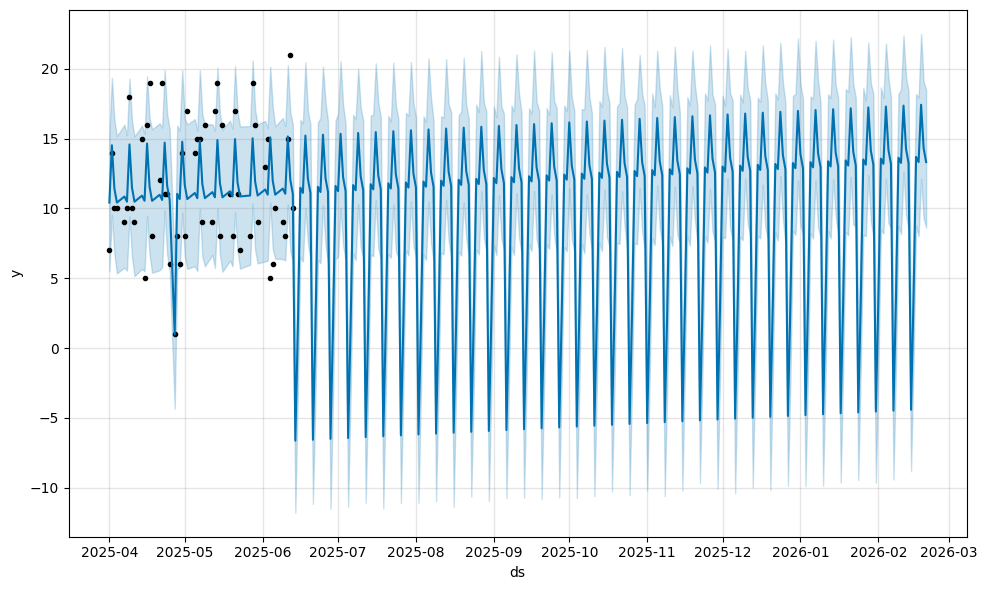

In [12]:
fig = m.plot(forecast)

In [ ]:
pandas_gbq.to_gbq(
    df_out, 
    destination_table="capacity_plan.prophet_run",
    project_id=project_id,
    if_exists="replace"
)